# Введение в предсказательное моделирование
## Домашнее задание №4
### Михаил Ховричев, 131 группа

In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
%matplotlib inline

In [5]:
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)
filename = 'train.csv'
df = pd.read_csv(filename)

## Задание 0

В датасете содержатся рукописных цифр от 0 до 9. Изображения серой тональности, кодируются интенсивностями серого от 0 до 255.

Всего 42000 записей. 

Признаков — 784 (разрешение 28х28, каждый признак *pixelx* обозначает интенсивность пикселя под данным номером *x*), они количественные. Дополнительная колонка — метка класса (смысл — какую цифру пытался изобразить испытуемый), по сути, целевая переменная.



In [6]:
print("# of samples:",df.shape[0])
print("# of classes:", len(df['label'].unique()))
print(df['label'].value_counts(sort=True))

# of samples: 42000
# of classes: 10
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64


Как видим, классы достаточно сбалансированы (нет классов-доминионов и микро-классов).

## Задание 1.1

Выпишем среднее выборки для каждого признака. Посчитаем ковариационную матрицу, выпишем её собственные числа и собственные векторы. Сделаем это дважды — вручную и с помощью пакета PCA. Далее покажем, что результаты совпадают.

In [7]:
Y = df['label']
X = df.drop('label', axis=1)
xmean = X.mean(axis=0)

print('Mean values of features:')
print(xmean.head(10))
print()
print('...')
print()
print(xmean.tail(10))

Mean values of features:
pixel0    0.0
pixel1    0.0
pixel2    0.0
pixel3    0.0
pixel4    0.0
pixel5    0.0
pixel6    0.0
pixel7    0.0
pixel8    0.0
pixel9    0.0
dtype: float64

...

pixel774    0.219286
pixel775    0.117095
pixel776    0.059024
pixel777    0.020190
pixel778    0.017238
pixel779    0.002857
pixel780    0.000000
pixel781    0.000000
pixel782    0.000000
pixel783    0.000000
dtype: float64


In [8]:
# centered X #
sc = StandardScaler(with_std=False)
X_norm = sc.fit_transform(X)
X_norm = pd.DataFrame(X_norm, columns=X.columns)
cov = X_norm.cov()
eig, eigvec = np.linalg.eig(cov)
idx = eig.argsort()[::-1]   
eig = eig[idx]
eigvec = eigvec[:,idx]

In [9]:
print('Eigen values of covariation matrix (descending order):')
print('\n'.join(str(eig.real[i]) for i in range(10)))
print()
print('...')
print()
print('\n'.join(str(eig.real[i]) for i in range(len(eig)-10, len(eig))))

Eigen values of covariation matrix (descending order):
334780.591494
245885.065138
211051.626988
184726.373428
168070.001507
147773.282741
112534.619456
99315.4374344
95016.014433
80660.7301899

...

0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.23395668126e-14
-2.22836500979e-13
-2.22836500979e-13


In [10]:
print('Eigen vectors of covariation matrix (descending order):')
print(eigvec.real)

Eigen vectors of covariation matrix (descending order):
[[ 0.  0.  0. ...,  0. -0. -0.]
 [ 0.  0.  0. ...,  0. -0. -0.]
 [ 0.  0.  0. ...,  0. -0. -0.]
 ..., 
 [ 0.  0.  0. ...,  0. -0. -0.]
 [ 0.  0.  0. ...,  0. -0. -0.]
 [ 0.  0.  0. ...,  0. -0. -0.]]


Теперь посмотрим на преобразованную выборку.

In [11]:
#PCA on my own
print(np.round(np.dot(X_norm, eigvec.real), decimals=4))

[[ -661.5958  -699.3113  -183.282  ...,     0.        -0.        -0.    ]
 [ 1701.4517  -360.5516   501.8056 ...,     0.        -0.        -0.    ]
 [ -886.8944  -293.7658   -67.1553 ...,     0.        -0.        -0.    ]
 ..., 
 [  336.27     950.0153   168.6054 ...,     0.        -0.        -0.    ]
 [  327.3994    62.0161  -697.5364 ...,    -0.        -0.        -0.    ]
 [ -364.2492   418.893    -62.8998 ...,     0.        -0.        -0.    ]]


А теперь — на результат применения PCA().

In [12]:
# PCA by Python
pca = PCA()
X_reduced = X.copy()
X_reduced = pca.fit_transform(X_reduced)
print(np.round(X_reduced, decimals=4))

[[ -661.5958  -699.3113   183.282  ...,     0.        -0.         0.    ]
 [ 1701.4517  -360.5516  -501.8056 ...,    -0.        -0.        -0.    ]
 [ -886.8944  -293.7658    67.1553 ...,    -0.        -0.         0.    ]
 ..., 
 [  336.27     950.0153  -168.6054 ...,     0.        -0.        -0.    ]
 [  327.3994    62.0161   697.5364 ...,     0.         0.         0.    ]
 [ -364.2492   418.893     62.8998 ...,     0.         0.        -0.    ]]


Результаты совпадают! Это значит, что не обязательно пользоваться PCA, если его нет под рукой.

Но раз есть — далее будем использовать его.

## Задание 1.2

Построим график собственных значений матрицы ковариации (объяснённые дисперсии).<br>
Рядом с ним построим график кумулятивной суммы доль объяснённой дисперсии (нормировка суммы собственных значений).

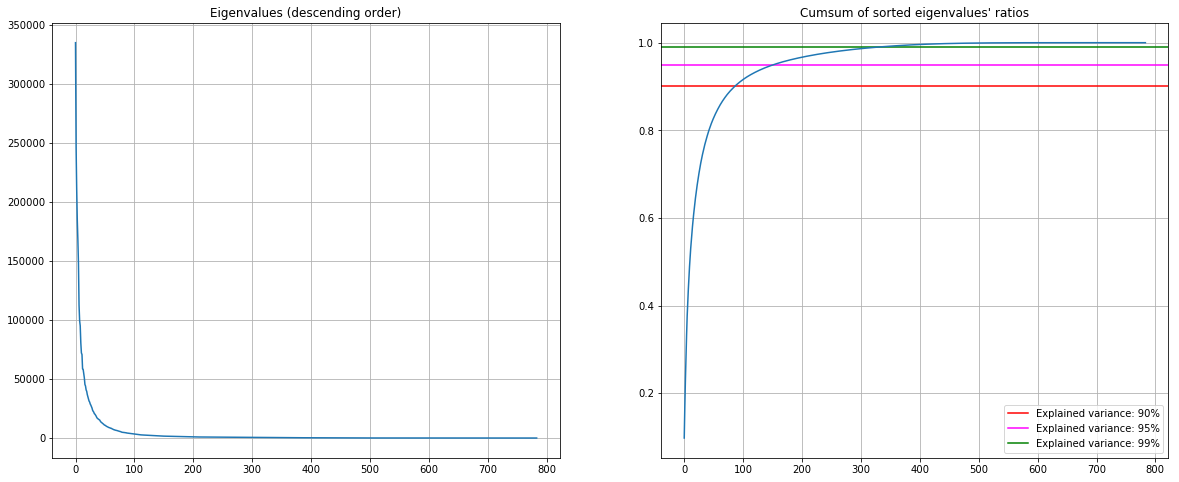

In [14]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(20,8))
axes[0].grid()
axes[0].set_title('Eigenvalues (descending order)')
axes[0].plot(list(range(28*28)), pca.explained_variance_)
axes[1].grid()
axes[1].set_title('Cumsum of sorted eigenvalues\' ratios')
axes[1].axhline(0.9, color='red', label='Explained variance: 90%')
axes[1].axhline(0.95, color='magenta', label='Explained variance: 95%')
axes[1].axhline(0.99, color='green', label='Explained variance: 99%')
axes[1].plot(list(range(28*28)),np.cumsum(pca.explained_variance_ratio_))
axes[1].legend(loc='best')

Размерность выборки зависит от нашего желания объяснить определённый процент дисперсии. В принципе, после СЧ под номером 100 другие СЧ особо не отличаются от нуля. Но всё же посчитаем точнее:

In [15]:
def d(expl):
    return min (n for n in range(28*28) if np.cumsum(pca.explained_variance_ratio_)[n] > expl)

dims = {83: d(0.83), 90: d(0.9), 95:d(0.95), 99:d(0.99)}
print("d (83 % of explained variance):", dims[83])
print("d (90 % of explained variance):", dims[90])
print("d (95 % of explained variance):", dims[95])
print("d (99 % of explained variance):", dims[99])

d (83 % of explained variance): 51
d (90 % of explained variance): 86
d (95 % of explained variance): 153
d (99 % of explained variance): 330


## Задание 1.3

Изобразим собственные векторы, отвечающие наибольшим СЧ, как изображения цифр. Для дополнительной контрастности, если она нам понадобится, умножим интенсивность на коэффициент $4200$ (попробованы разные, этот приятнее глазу). 

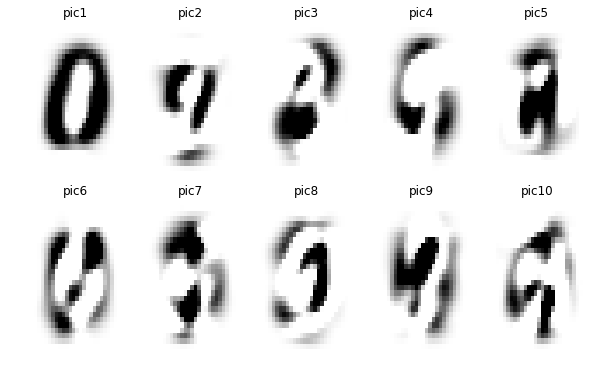

In [16]:
#1.3
def vec2mat(vec, contr):
    if contr==1:
        vec = np.asarray([4200*t for t in vec.real]) # contrast
    mat = vec.reshape((28, 28)).astype('float')
    return mat

for k in range(10):
    plt.subplot(2, 5, k+1)
    mat = vec2mat(pca.components_[k],1)
    plt.imshow(mat, cmap='gray_r', vmin=0, vmax=255, interpolation="nearest")
    plt.axis('off')
    plt.axis('tight')
    plt.title('pic'+str(k+1))
    
plt.show()

Получилось что-то не очень распознаваемое человеческим глазом. Первый вектор — $0$. Насчёт остальных можно тольео догадываться, особенно в нижнем ряду.

## Задание 1.4

Нарисуем проекции исходных цифр на пространства, где объясняется $83, 90, 95, 99$ % дисперсии соответственно. Размерности этих пространств посчитаны выше.

In [17]:
#1.4
ind = []
for i in range(10):
    ind.append(df[df['label']==i].index.tolist()[0])

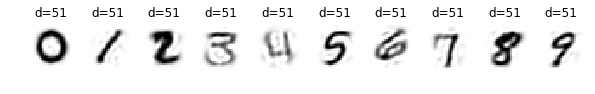

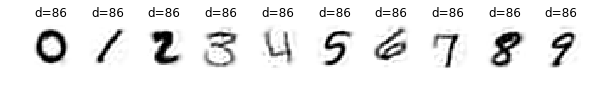

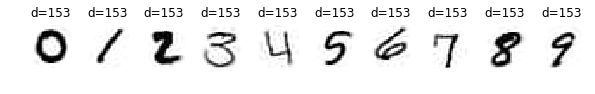

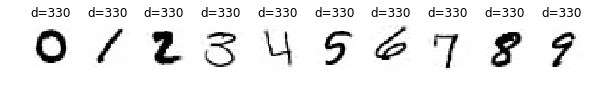

In [18]:
for ev,dim in dims.items():
    pca = PCA(n_components=dim)
    pca.fit(X)
    
    for i in range(10):
        plt.subplot(1, 10, i+1)
        c = np.asarray(X)
        c = pca.transform(c)
        c = pca.inverse_transform(c)
        c = vec2mat(c[ind[i]],0)
        plt.imshow(c,cmap='gray_r', vmin=0, vmax=255, interpolation='nearest')
        plt.axis('off')
        plt.title('d='+str(dim))
    plt.show()

## Задание 1.5

Очевидно, с увеличением размерности, увеличивается и чёткость цифр.

Адекватно текст воспринимается начиная с $d=86$, причём $d=330$ не имеет шума.

Можно сделать вывод, что размерность данных $\hat{d} \in [86; 330]$.

## Задание 2.

Результаты представлены для одного класса, чтобы не плодить сущности. Посмотреть, что происходит с другими классами можно, изменив переменную lbl в самом начале батча.

In [57]:
lbl=5
# sample for subset with label 5
df2 = df[df['label']==lbl]
Y = df2['label']
X = df2.drop('label', axis=1)
xmean = X.mean(axis=0)

print('Mean values of features:')
print(xmean.head(10))
print()
print('...')
print()
print(xmean.tail(10))

Mean values of features:
pixel0    0.0
pixel1    0.0
pixel2    0.0
pixel3    0.0
pixel4    0.0
pixel5    0.0
pixel6    0.0
pixel7    0.0
pixel8    0.0
pixel9    0.0
dtype: float64

...

pixel774    0.0
pixel775    0.0
pixel776    0.0
pixel777    0.0
pixel778    0.0
pixel779    0.0
pixel780    0.0
pixel781    0.0
pixel782    0.0
pixel783    0.0
dtype: float64


In [58]:
sc = StandardScaler(with_std=False)
X_norm = sc.fit_transform(X)
X_norm = pd.DataFrame(X_norm, columns=X.columns)
cov = X_norm.cov()
eig, eigvec = np.linalg.eig(cov)
idx = eig.argsort()[::-1]   
eig = eig[idx]
eigvec = eigvec[:,idx]

print('Eigen values of covariation matrix (descending order):')
print('\n'.join(str(eig.real[i]) for i in range(10)))
print()
print('...')
print()
print('\n'.join(str(eig.real[i]) for i in range(len(eig)-10, len(eig))))

Eigen values of covariation matrix (descending order):
520925.880123
296184.383938
218672.957066
157068.612176
117985.827358
103193.414012
95710.3465824
75878.6839619
67082.8510084
66014.1993319

...

0.0
0.0
-6.79184875772e-14
-1.61995049068e-13
-1.61995049068e-13
-2.24712221333e-13
-3.51183134759e-13
-9.73882596046e-13
-1.27424877307e-12
-2.21659533699e-12


In [59]:
print('Eigen vectors of covariation matrix (descending order):')
print(eigvec.real)

Eigen vectors of covariation matrix (descending order):
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [60]:
#PCA on my own
print(np.round(np.dot(X_norm, eigvec.real), decimals=4))

[[  635.9387  -559.0395    29.4184 ...,    -0.         0.         0.    ]
 [ 1217.2479   536.9658    36.2519 ...,    -0.         0.        -0.    ]
 [ 1240.2243   841.266     -2.107  ...,    -0.         0.        -0.    ]
 ..., 
 [  525.6609   796.7557   286.3484 ...,     0.        -0.         0.    ]
 [ 1030.5952   184.5637  -261.0466 ...,     0.        -0.         0.    ]
 [ 1161.9821   163.7123   309.2363 ...,     0.         0.         0.    ]]


In [61]:
#PCA by Python
pca = PCA()
X_reduced = X.copy()
X_reduced = pca.fit_transform(X_reduced)
print(np.round(X_reduced, decimals=4))

[[  635.9387   559.0395   -29.4184 ...,     0.        -0.         0.    ]
 [ 1217.2479  -536.9658   -36.2519 ...,    -0.         0.        -0.    ]
 [ 1240.2243  -841.266      2.107  ...,    -0.        -0.         0.    ]
 ..., 
 [  525.6609  -796.7557  -286.3484 ...,    -0.        -0.        -0.    ]
 [ 1030.5952  -184.5637   261.0466 ...,    -0.        -0.         0.    ]
 [ 1161.9821  -163.7123  -309.2363 ...,    -0.         0.         0.    ]]


*Снова совпадают!*

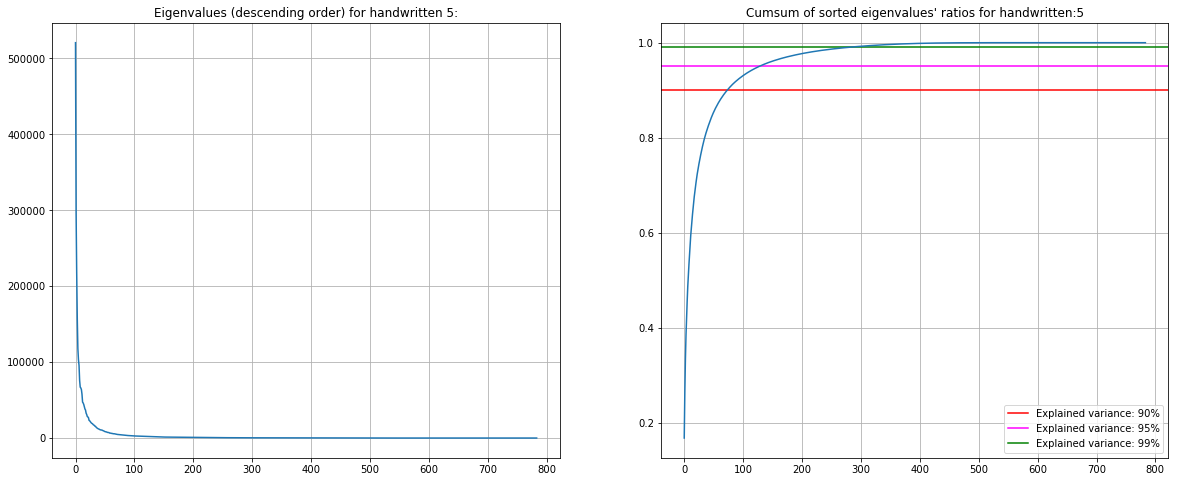

In [62]:
## eigenvalues, cumsum(ev_ratio) ##
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(20,8))
axes[0].grid()
axes[0].set_title('Eigenvalues (descending order) for handwritten 5:')
axes[0].plot(list(range(28*28)), pca.explained_variance_)
axes[1].grid()
axes[1].set_title('Cumsum of sorted eigenvalues\' ratios for handwritten:'+str(lbl))
axes[1].axhline(0.9, color='red', label='Explained variance: 90%')
axes[1].axhline(0.95, color='magenta', label='Explained variance: 95%')
axes[1].axhline(0.99, color='green', label='Explained variance: 99%')
axes[1].plot(list(range(28*28)),np.cumsum(pca.explained_variance_ratio_))
axes[1].legend(loc='best')

In [63]:
## dimensions ##
def d(expl):
    return min (n for n in range(28*28) if np.cumsum(pca.explained_variance_ratio_)[n] > expl)

dims = {83: d(0.83), 90: d(0.9), 95:d(0.95), 99:d(0.99)}
print("d (83 % of explained variance):", dims[83])
print("d (90 % of explained variance):", dims[90])
print("d (95 % of explained variance):", dims[95])
print("d (99 % of explained variance):", dims[99])

d (83 % of explained variance): 43
d (90 % of explained variance): 73
d (95 % of explained variance): 128
d (99 % of explained variance): 277


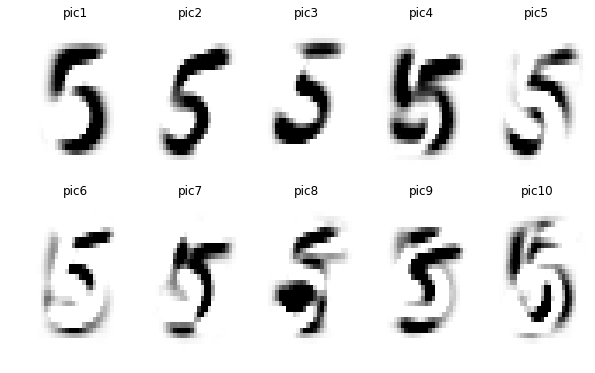

In [27]:
## top-10 vectors ##
for k in range(10):
    plt.subplot(2, 5, k+1)
    mat = vec2mat(pca.components_[k],1)
    plt.imshow(mat, cmap='gray_r', vmin=0, vmax=255, interpolation="nearest")
    plt.axis('off')
    plt.axis('tight')
    plt.title('pic'+str(k+1))
    
plt.show()

Здесь пятёрка различима гораздо лучше. Хотя на нижней строчке снова постепенная потеря различимости.

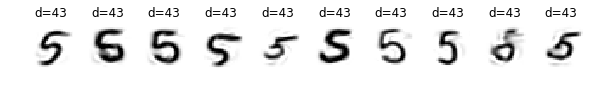

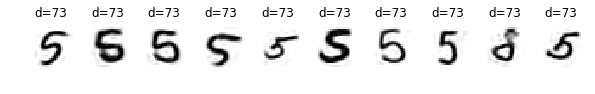

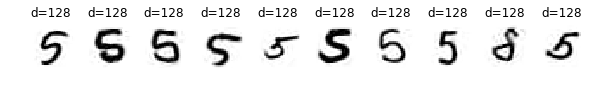

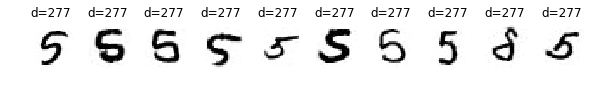

In [28]:
## projections ##
for ev,dim in dims.items():
    pca = PCA(n_components=dim)
    pca.fit(X)
    
    for i in range(10):
        plt.subplot(1, 10, i+1)
        c = np.asarray(X)
        c = pca.transform(c)
        c = pca.inverse_transform(c)
        c = vec2mat(c[i],0)
        plt.imshow(c,cmap='gray_r', vmin=0, vmax=255, interpolation='nearest')
        plt.axis('off')
        plt.title('d='+str(dim))
    plt.show()

Интересное наблюдение: предпоследний символ подозрительно похож на восьмёрку. Но, может быть, всё дело в почерке.

Так или иначе, наблюдения могут лежать примерно: $\hat{d}_5 \in [73; 277]$.

Повторюсь — для получения результатов по всем остальным классам достаточно заменить значение переменной.

## Задание 3.1

Выпуклая комбинация пары цифр: 

$mix = \alpha*digit_1 + (1-\alpha)*digit_2, \quad \alpha \sim R[0;1] $

В исходном пространстве получаем следующие картинки (без обработки контрастом и центрирования, хотя в коде всё предусмотрено):

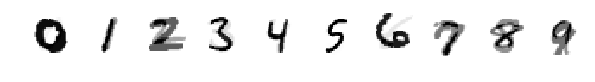

In [33]:
Y = df['label']
X = df.drop('label', axis=1)
X_norm = sc.fit_transform(X)
X_norm = pd.DataFrame(X_norm, columns=X.columns)

random.seed(0)
mixes = []
for i in range(10):
    lis_ind = df[df['label']==i].index.tolist() #indexes for every digit
    rand_idx = random.sample(lis_ind, 2) # pair of random indexes
    digit1 = X.loc[[rand_idx[0]]].values[0]
    digit2 = X.loc[[rand_idx[1]]].values[0]
    alpha = random.uniform(0, 1)
    
    mix = alpha*digit1+(1-alpha)*digit2
    
    plt.subplot(1, 10, i+1)
    mat = vec2mat(mix, 0)
    plt.imshow(mat, cmap=plt.cm.gray_r, vmin=0, vmax=255, interpolation="nearest")
    plt.axis('off')

    # for normalized data just in case
    digit1_norm = X_norm.loc[[rand_idx[0]]].values[0]
    digit2_norm = X_norm.loc[[rand_idx[1]]].values[0]
    mix_norm = alpha*digit1_norm+(1-alpha)*digit2_norm
    
    mixes.append(mix)
plt.show()  

## Задание 3.2

Теперь нарисуем цифры, получаемые как выпуклые комбинации пары цифр в сжатом пространстве <br>
(для всё тех же размерностей, объясняющих $83,90,95,99$ % дисперсии):

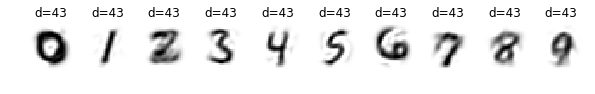

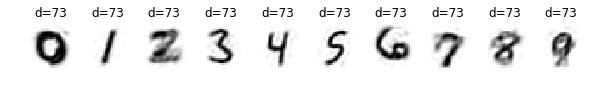

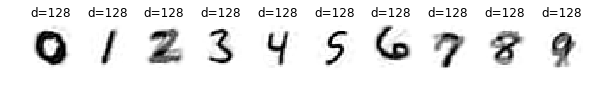

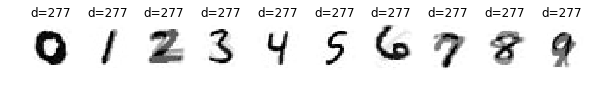

In [55]:
#task3.2
for ev,dim in dims.items():
    pca = PCA(n_components=dim)
    pca.fit(X)
    
    for i in range(10):   
        plt.subplot(1, 10, i+1)
        c = mixes
        c = pca.transform(c)
        c = pca.inverse_transform(c)
        mat = vec2mat(c[i],0)
        plt.imshow(mat, cmap='gray_r', vmin=0, vmax=255, interpolation="nearest")
        plt.axis('off')
        plt.title('d='+str(dim))
    plt.show()

Чёткость повышается с увеличением $d$, но здесь можем говорить о различимости лишь с $d=128$.